# **Load Model**

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import keras.utils as image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the pre-trained model

model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Research project/Adversarial training/saved modeladv_base_epoch6.h5')


# **Copy random test images to experiment with**

In [ ]:
import os
import random
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
src_folder1 = '/content/drive/MyDrive/Colab Notebooks/Research project/Adversarial training/data/test3/infected'
src_folder2 = '/content/drive/MyDrive/Colab Notebooks/Research project/Adversarial training/data/test3/uninfected'

dst_folder1 = '/content/drive/MyDrive/Colab Notebooks/Research project/Adversarial training/experiment images/infected'
dst_folder2 = '/content/drive/MyDrive/Colab Notebooks/Research project/Adversarial training/experiment images/uninfected'

In [ ]:
files_class1 = os.listdir(src_folder1)
files_class2 = os.listdir(src_folder2)

In [ ]:
random_images_class1 = random.sample(files_class1, 100)
random_images_class2 = random.sample(files_class2, 100)

In [ ]:
# Copy random images to destination folders

for image_file in random_images_class1:
    source_path = os.path.join(src_folder1, image_file)
    destination_path = os.path.join(dst_folder1, image_file)
    shutil.copy(source_path, destination_path)

for image_file in random_images_class2:
    source_path = os.path.join(src_folder2, image_file)
    destination_path = os.path.join(dst_folder2, image_file)
    shutil.copy(source_path, destination_path)


**Load test data**

In [ ]:
data_dir1 = '/content/drive/MyDrive/Colab Notebooks/Research project/Adversarial training/data/test3'

In [ ]:

def get_images(data_dir):
  class_names = os.listdir(data_dir)

  images = []
  labels = []

# Get images from directory
  for class_name in class_names:
      class_dir = os.path.join(data_dir, class_name)
      for image_name in os.listdir(class_dir):
          image_path = os.path.join(class_dir, image_name)
          img = cv2.imread(image_path)
          img = cv2.resize(img, (150, 150))
          img = img / 255.0
          images.append(img)
          labels.append(class_name)
  return images, labels

In [ ]:
images1, labels1 = get_images(data_dir1)

In [ ]:
len(images1) , len(labels1)

(453, 453)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels1)

In [ ]:
# split training and test data

x_train1, x_test1, y_train1, y_test1 = train_test_split(images1, y, test_size=0.95, random_state=None)

In [ ]:

x_train1 = np.array(x_train1)  # Convert the list to a NumPy array
x_test1 = np.array(x_test1)  # Convert the list to a NumPy array

# Reshape the arrays to (1, 150, 150, 3)
x_train1 = x_train1.reshape(-1, 150, 150, 3)
x_test1 = x_test1.reshape(-1, 150, 150, 3)


In [ ]:
x_test1.shape

(431, 150, 150, 3)

In [ ]:
x_train1.shape

(22, 150, 150, 3)

# **Predictions**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:

image_datagen = ImageDataGenerator(rescale = 1./255)


In [ ]:
# Load and preprocess the input image

img_path = '/content/drive/MyDrive/Colab Notebooks/Research project/Adversarial training/experiment images/infected/20170613_160823.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

In [ ]:
prp_img = image_datagen.standardize(img)

In [ ]:
prp_img.shape

(1, 150, 150, 3)

In [ ]:
pred1 = model.predict(prp_img)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
def prediction(pred):
  predicted_class_index = 1 if pred >= 0.5 else 0

  return predicted_class_index


In [ ]:
prediction(pred1)

0

# **Generate adversarial examples**

In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:
import art
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
help(art.defences.trainer.adversarial_trainer)

In [ ]:
classifier = KerasClassifier(clip_values=(0, 1), model= model, use_logits=False)

In [ ]:
attack1 = FastGradientMethod(classifier, eps=2)
attack2 = ProjectedGradientDescent(classifier, eps = 0.1, eps_step=0.01, max_iter=50)


# **Example with one image**

In [ ]:
adv_eg = attack2.generate(prp_img)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
adv_pred = model.predict(adv_eg)

In [ ]:
prediction(adv_pred)

0

In [ ]:
pertubation = prp_img - adv_eg

pertubation = np.squeeze(pertubation, axis =0)

In [ ]:
image = np.squeeze(prp_img, axis = 0)

In [ ]:
adv_image = np.squeeze(adv_eg, axis = 0)

In [ ]:
pertubation.shape

(150, 150, 3)

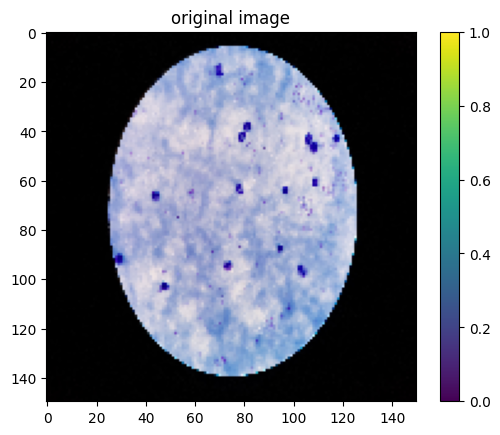

In [ ]:
plt.imshow(image, cmap='viridis')  # Change the cmap parameter to choose a different colormap.
plt.colorbar()  # Add a colorbar for reference.
plt.title('original image')
plt.show()

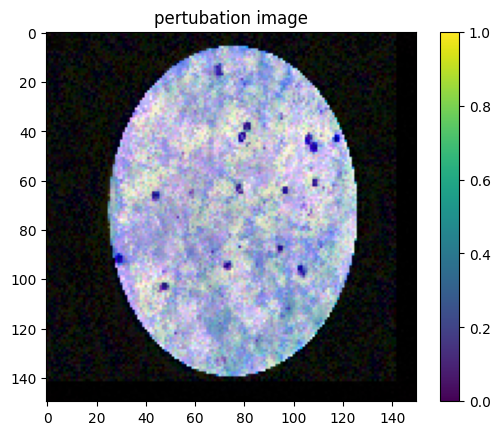

In [ ]:
plt.imshow(adv_image, cmap='viridis')  # Change the cmap parameter to choose a different colormap.
plt.colorbar()  # Add a colorbar for reference.
plt.title('pertubation image')
plt.show()

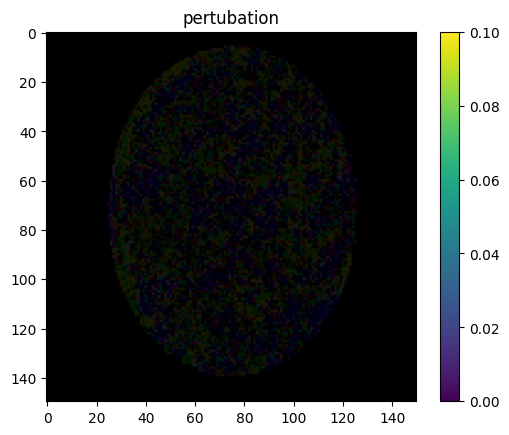

In [ ]:
plt.imshow(pertubation, cmap='viridis')  # Change the cmap parameter to choose a different colormap.
plt.colorbar()  # Add a colorbar for reference.
plt.title('pertubation')
plt.show()

# **Batch of images**

**Evaluate baseline classifier**

In [ ]:
pred1 = classifier.predict(x_test1)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
pred1.shape

(431, 1)

In [ ]:

def pred_results(pred, y_test):
  # reshape pred
  pred = pred.reshape(-1)

  # Convert predicted probabilities to binary predictions (0 or 1)
  y_pred = (pred >= 0.5).astype(int)

  # Count the number of correct predictions
  nb_images = len(y_test)
  nb_correct_pred = np.sum(y_pred == y_test)
  nb_incorrect_pred = nb_images - nb_correct_pred

  #print results
  print('Number of images:{}'.format(nb_images))
  print('Number of correct classifications:{}'.format(nb_correct_pred))
  print('Number of incorrect classifications:{}'.format(nb_incorrect_pred))
  print('Accuracy:{}'.format((nb_correct_pred/len(y_test))*100))


In [ ]:
pred_results(pred1, y_test1)

Number of images:431
Number of correct classifications:319
Number of incorrect classifications:112
Accuracy:74.0139211136891


**Evaluate adversarial examples**

In [ ]:
# FGSM adversarial examples

x_adv1 = attack1.generate(x_test1)

pred1_adv = classifier.predict(x_adv1)

In [ ]:
pred1_adv.shape

(431, 1)

In [ ]:
pred_results(pred1_adv, y_test1)

Number of images:431
Number of correct classifications:165
Number of incorrect classifications:266
Accuracy:38.2830626450116


In [ ]:
# PGD adversarial examples

x_adv12 = attack2.generate(x_test1)

pred12_adv = classifier.predict(x_adv12)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
pred1_adv.shape

(431, 1)

In [ ]:
pred_results(pred12_adv, y_test1)

Number of images:431
Number of correct classifications:267
Number of incorrect classifications:164
Accuracy:61.94895591647332


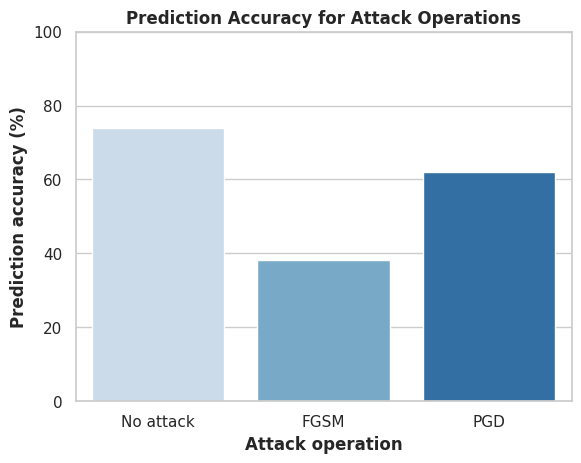

In [ ]:
# Plot results for original classifier

categories = ['No attack', 'FGSM', 'PGD']
pred_accuracy = [74, 38.3, 61.9]

sns.set(style="whitegrid")  # Set the style of the chart
plt.figure()

# Create the bar chart
sns.barplot(x=categories, y=pred_accuracy, palette="Blues")

plt.ylim(0,100)
# Customize the plot
plt.title("Prediction Accuracy for Attack Operations", fontweight = 'bold')
plt.xlabel("Attack operation", fontweight = 'bold')
plt.ylabel("Prediction accuracy (%)", fontweight = 'bold')

# Show the plot
plt.show()


# **Adversarial training**

In [ ]:
from keras import layers
from keras import models
import pickle

In [ ]:
# Develop robust model

robust_model = models.Sequential()
robust_model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
robust_model.add(layers.MaxPooling2D((2, 2)))
robust_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
robust_model.add(layers.MaxPooling2D((2, 2)))
robust_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
robust_model.add(layers.MaxPooling2D((2, 2)))
robust_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
robust_model.add(layers.MaxPooling2D((2, 2)))
robust_model.add(layers.Flatten())
robust_model.add(layers.Dense(1024, activation='relu'))
robust_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
robust_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
robust_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

**Load Training Data**

In [ ]:
data_dir2 = '/content/drive/MyDrive/Colab Notebooks/Research project/Adversarial training/data/train3'

In [ ]:
images2, labels2 = get_images(data_dir2)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y2 = label_encoder.fit_transform(labels2)

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(images2, y2, test_size=0.5, random_state=None)

In [ ]:

x_train2 = np.array(x_train2)  # Convert the list to a NumPy array
x_test2 = np.array(x_test2)  # Convert the list to a NumPy array

# Reshape the arrays to (1, 150, 150, 3)
x_train2 = x_train2.reshape(-1, 150, 150, 3)
x_test2 = x_test2.reshape(-1, 150, 150, 3)


In [ ]:
x_train2.shape

(463, 150, 150, 3)

In [ ]:
x_test2.shape

(1642, 150, 150, 3)

**Train robust classifier**

In [ ]:
robust_classifier = KerasClassifier(clip_values= (0,1), model= robust_model)

In [ ]:
attack3 = FastGradientMethod(robust_classifier, eps=2)
attack4 = ProjectedGradientDescent(robust_classifier, eps = 2, eps_step=0.01, max_iter=50)

In [ ]:
attacks = [attack3, attack4]

In [ ]:
# Adversarial training

trainer = AdversarialTrainer(robust_classifier, attacks, ratio=0.5)
trainer.fit(x_train2, y_train2, nb_epochs=6, batch_size=30)

trainer.classifier.model.save('/content/drive/MyDrive/Colab Notebooks/Research project/Adversarial training/robust_model_eps22.h5')

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


**Evaluate Robust Classifier: eps = 2**

In [ ]:
# Load robust model

rob_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Research project/Adversarial training/robust_model_eps22.h5')

In [ ]:
# Set classifier

classifier2 = KerasClassifier(clip_values=(0, 1), model= rob_model, use_logits=False)

In [ ]:
# Evaluate on test2 data

pred2 = classifier2.predict(x_test2)

pred_results(pred2, y_test2)

Number of images:1053
Number of correct classifications:1053
Number of incorrect classifications:0
Accuracy:100.0


In [ ]:
# Evaluate on advesarial examples: FGSM

x_adv2 = attack3.generate(x_test2)
pred2_adv = classifier2.predict(x_adv2)

pred_results(pred2_adv, y_test2)

Number of images:1053
Number of correct classifications:804
Number of incorrect classifications:249
Accuracy:76.35327635327636


In [ ]:
# PGD

x_adv21 = attack4.generate(x_test2)
pred21_adv = classifier2.predict(x_adv21)


pred_results(pred21_adv, y_test2)

Number of images:1053
Number of correct classifications:804
Number of incorrect classifications:249
Accuracy:76.35327635327636


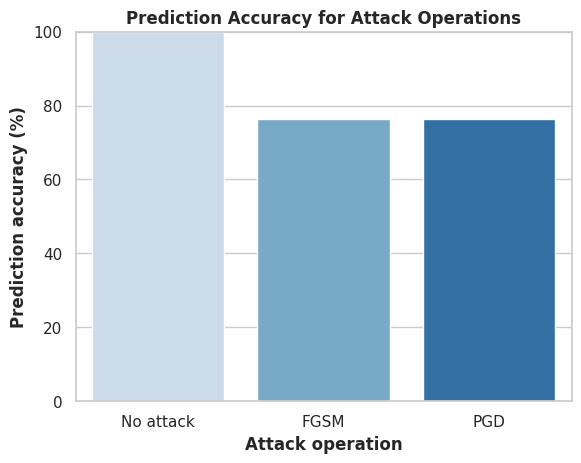

In [ ]:
# Plot results for original classifier

categories = ['No attack', 'FGSM', 'PGD']
pred_accuracy = [100, 76.4, 76.4]

sns.set(style="whitegrid")  # Set the style of the chart
plt.figure()

# Create the bar chart
sns.barplot(x=categories, y=pred_accuracy, palette="Blues")

plt.ylim(0,100)
# Customize the plot
plt.title("Prediction Accuracy for Attack Operations", fontweight = 'bold')
plt.xlabel("Attack operation", fontweight = 'bold')
plt.ylabel("Prediction accuracy (%)", fontweight = 'bold')

# Show the plot
plt.show()


**Compare performance of the original and robust classifier for a range of eps**

In [ ]:
fgsm_attack = attack1
fgsm_robust_attack = attack3

pgd_attack = attack2
pgd_robust_attack = attack4

In [ ]:

def pred_accu(pred, y_test):
  # reshape pred
  pred = pred.reshape(-1)

  # Convert predicted probabilities to binary predictions (0 or 1)
  y_pred = (pred >= 0.5).astype(int)

  # Count the number of correct predictions
  nb_images = len(y_test)
  nb_correct_pred = np.sum(y_pred == y_test)
  nb_incorrect_pred = nb_images - nb_correct_pred

  accuracy = (nb_correct_pred/nb_images) * 100

  return accuracy



In [ ]:
# FGSM

eps_range = np.arange(0,2.6,0.2)
original_accu = []
robust_accu = []
nb_samples = 100

for eps in eps_range:
  fgsm_attack.set_params(**{'eps': eps})
  fgsm_robust_attack.set_params(**{'eps': eps})
  x_adv = fgsm_attack.generate(x_test1[:nb_samples], y_test1[:nb_samples])
  xrob_adv = fgsm_robust_attack.generate(x_test2[:nb_samples], y_test2[:nb_samples])

  pred_x_adv = classifier.predict(x_adv)
  original_accu += [pred_accu(pred_x_adv, y_test1[:nb_samples])]

  pred_xrob_adv = classifier2.predict(xrob_adv)
  robust_accu += [pred_accu(pred_xrob_adv, y_test2[:nb_samples])]

# Print accuracy lists
print(original_accu)
print(robust_accu)

[77.0, 77.0, 77.0, 76.0, 51.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0]
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


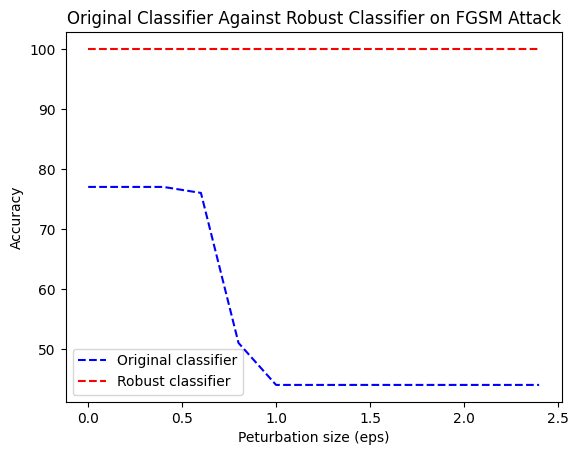

In [ ]:
# Plot curve

fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(original_accu), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(robust_accu), 'r--', label='Robust classifier')

legend = ax.legend()

plt.title('Original Classifier Against Robust Classifier on FGSM Attack')
plt.xlabel('Peturbation size (eps)')
plt.ylabel('Accuracy')
plt.show()

#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Research project/Adversarial training/saved model/adversarial results1.png')